In [8]:
import numpy as np
from copy import deepcopy

from surprise import SVD
from surprise import Dataset
from surprise.accuracy import rmse

from surprise.model_selection import train_test_split
from surprise.similarities import cosine
from Uncertain.SVDAverageEnsemble import SamplingAverageEnsemble
from Uncertain.metrics import rmse as urmse

import matplotlib.pyplot as plt

data = Dataset.load_builtin('ml-100k')
train, test = train_test_split(data, test_size=0.01, random_state=0)
nu = train.n_users
ni = train.n_items

ensemble = 50
epochs = 20
factors = 100
algo = SVD(n_epochs=epochs, n_factors=factors, random_state=0)
baseline = rmse(algo.fit(train).test(test))

RMSE: 0.9538


## Varying seeds

Min RMSE = 0.9475 ; Max RMSE = 0.9783
Full ensemble RMSE: 0.941299034304631


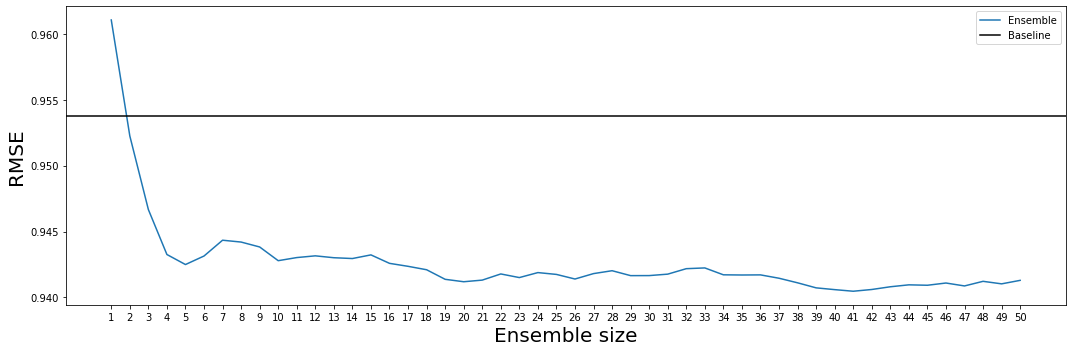

In [9]:
model2 = SamplingAverageEnsemble(algo, n=ensemble)
model2.fit(train, fixed_seed_models=False)
preds2 = model2.base_estimate(test)
RMSE2 = np.empty((ensemble))
for i in range(ensemble):
    RMSE2[i] = rmse(preds2[i], verbose=False)
print('Min RMSE =', round(np.min(RMSE2), 4), '; Max RMSE =', round(np.max(RMSE2), 4))

model_ = deepcopy(model2)
eRMSE2 = np.empty((ensemble))
for i in range(ensemble):
    model_.models = model2.models[:i+1]
    upreds2 = model_.test(test)
    eRMSE2[i] = urmse(upreds2, verbose=False)

f, ax = plt.subplots(figsize=(15,5))
ax.plot(range(1, ensemble+1), eRMSE2, label='Ensemble')
ax.axhline(y=baseline, color='black', label='Baseline')
ax.set_xticks(range(1, ensemble+1))
ax.set_xlabel('Ensemble size', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('sample/RMSE vs Size2.pdf')
print('Full ensemble RMSE:', eRMSE2[-1])

## Fixed seeds

Min RMSE = 0.953 ; Max RMSE = 0.967
Full ensemble RMSE: 0.9564334362306306


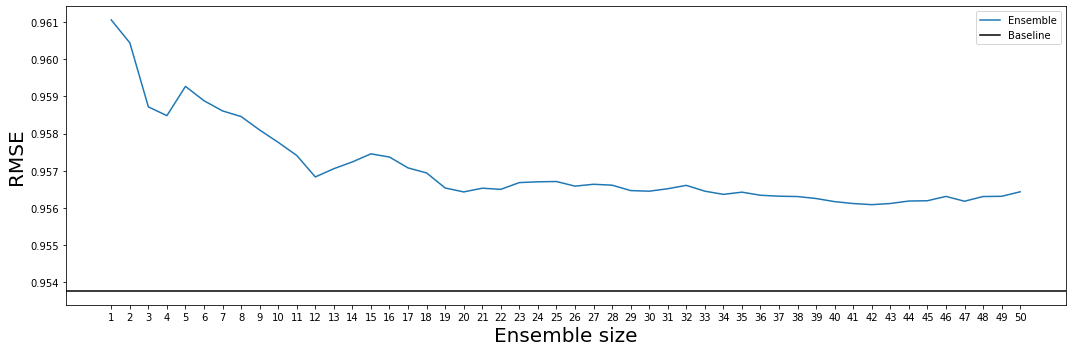

In [10]:
model = SamplingAverageEnsemble(algo, n=ensemble)
model.fit(train, fixed_seed_models=True)
preds = model.base_estimate(test)
RMSE = np.empty((ensemble))
for i in range(ensemble):
    RMSE[i] = rmse(preds[i], verbose=False)
print('Min RMSE =', round(np.min(RMSE), 4), '; Max RMSE =', round(np.max(RMSE), 4))

model_ = deepcopy(model)
eRMSE = np.empty((ensemble))
for i in range(ensemble):
    model_.models = model.models[:i+1]
    upreds = model_.test(test)
    eRMSE[i] = urmse(upreds, verbose=False)

f, ax = plt.subplots(figsize=(15,5))
ax.plot(range(1, ensemble+1), eRMSE, label='Ensemble')
ax.axhline(y=baseline, color='black', label='Baseline')
ax.set_xticks(range(1, ensemble+1))
ax.set_xlabel('Ensemble size', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('sample/RMSE vs Size.pdf')
print('Full ensemble RMSE:', eRMSE[-1])

In [11]:
model.predict('1', '1', verbose=True)
model.predict('1', '1000', verbose=True)

user: 1          item: 1          r_ui = 5.00   est = 4.65   unc = 0.12   {'was_impossible': False}
user: 1          item: 1000       r_ui = None   est = 2.85   unc = 0.08   {'was_impossible': False}


UncertainPrediction(uid='1', iid='1000', r_ui=None, est=2.8532126772793878, unc=0.0775911058795041, details={'was_impossible': False})

array([[ 1.        ,  0.07351041,  0.26787059],
       [ 0.07351041,  1.        , -0.04340976],
       [ 0.26787059, -0.04340976,  1.        ]])

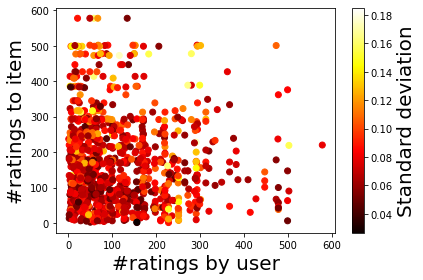

In [12]:
uids = np.unique([i.uid for i in upreds])
iids = np.unique([i.iid for i in upreds])

nu = [len(train.ir[train.to_inner_uid(uid)]) for uid in uids]
ni = np.empty((len(iids)))
for i, iid in enumerate(iids):
    try:
        ni[i] = len(train.ir[train.to_inner_iid(iid)])
    except:
        ni[i] = 0
        
pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    pred_n[i] = [upreds[i].unc, nu[np.where(upreds[i].uid == uids)[0][0]], ni[np.where(upreds[i].iid == iids)[0][0]]]
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('#ratings by user', Fontsize=20)
ax.set_ylabel('#ratings to item', Fontsize=20)
f.tight_layout()
f.savefig('sample/SD distribution.pdf')
np.corrcoef(pred_n.T)

array([[ 1.        , -0.26156857, -0.05346372],
       [-0.26156857,  1.        ,  0.16777587],
       [-0.05346372,  0.16777587,  1.        ]])

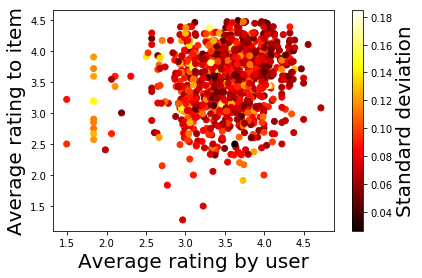

In [13]:
avgu = [np.mean([t[1] for t in train.ur[train.to_inner_uid(uid)]]) for uid in uids]
avgi = np.empty((len(iids)))
for i, iid in enumerate(iids):
    try:
        avgi[i] = np.mean([t[1] for t in train.ir[train.to_inner_iid(iid)]])
    except:
        avgi[i] = train.global_mean

pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    pred_n[i] = [upreds[i].unc, avgu[np.where(upreds[i].uid == uids)[0][0]], avgi[np.where(upreds[i].iid == iids)[0][0]]]
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('Average rating by user', Fontsize=20)
ax.set_ylabel('Average rating to item', Fontsize=20)
f.tight_layout()
f.savefig('sample/SD distribution2.pdf')

np.corrcoef(pred_n.T)

array([[ 1.        , -0.50368884, -0.15426692],
       [-0.50368884,  1.        ,  0.07034586],
       [-0.15426692,  0.07034586,  1.        ]])

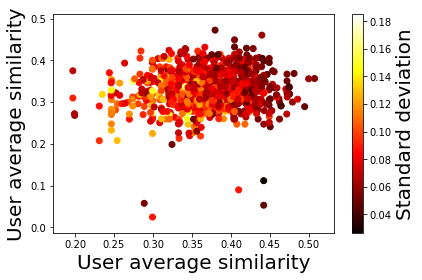

In [14]:
simu = model.models[0].compute_similarities().mean(axis=0)
model.models[1].sim_options['user_based'] = False
simi = model.models[1].compute_similarities().mean(axis=0)

pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    try:
        pred_n[i] = [upreds[i].unc, simu[train.to_inner_uid(upreds[i].uid)], simi[train.to_inner_iid(upreds[i].iid)]]
    except:
        pass
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('User average similarity', Fontsize=20)
ax.set_ylabel('User average similarity', Fontsize=20)
f.tight_layout()
f.savefig('sample/SD distribution3.pdf')

np.corrcoef(pred_n.T)